In [1]:
import collections
# Prepare paths to local utilities
import os
import sys
import pickle

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [3]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.DatasetPreparation import DatasetPreparation
    from processing.DataPreprocessor import DataPreprocessor
    from reservoir.HierarchyESNCuda import HierarchyESNCuda as HierarchyESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from hierarchyesn.HierarchyESNCuda import HierarchyESNCuda as HierarchyESN
    from esnutil.esnutil import generate_input_weights

In [4]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
data_preparation = DatasetPreparation()

input_features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_features = ['label']

data_preparation.prepare_dataset('har70plus', input_features, output_features)

Dataset already downloaded
Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data\har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes
Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]
Number of frames in training set: 17
Number of frames in validation set: 17
Number of frames in testing set: 18
X_train shape: (1357646, 6), Y_train shape: (1357646,)
X_val shape: (339404, 6), Y_val shape: (339404,)
X_test shape: (562547, 6), Y_test shape: (562547,)
Y_train encoded shape: (1357646, 7)
Y_val encoded shape: (339404, 7)
Y_test encoded shape: (562547, 7)
Y_train decoded shape: (1357646, 1)
Y_val decoded shape: (339404, 1)
Y_test decoded shape: (562547, 1)
X_train scaled shape: (1357646, 6)
X_val scaled shape: (339404, 6)
X_test scaled shape

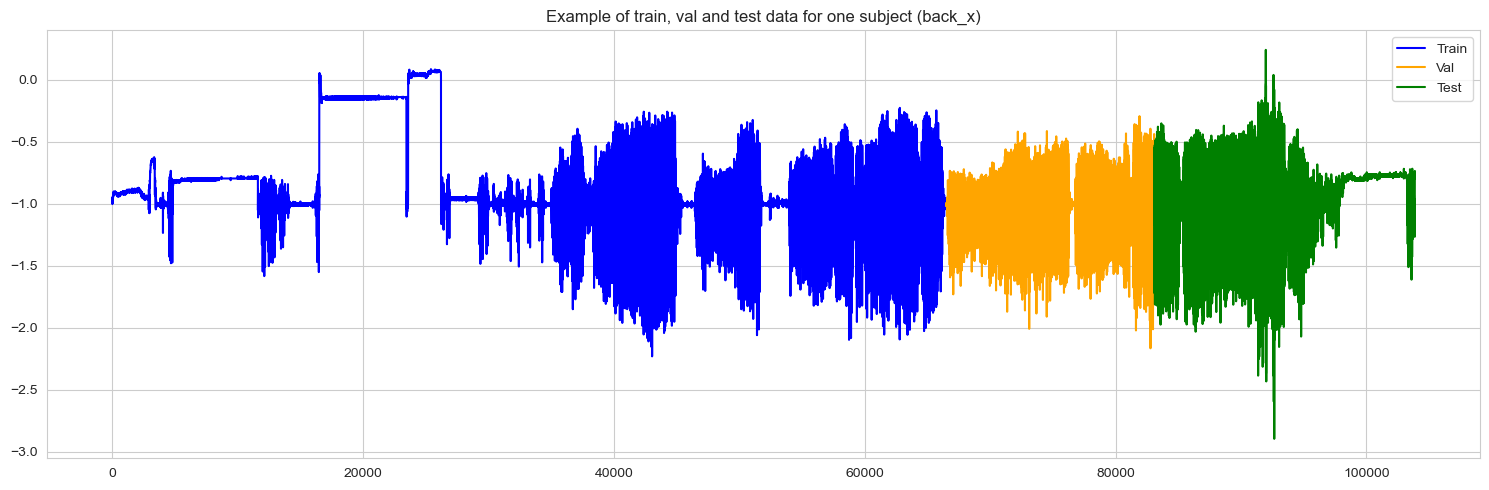

In [6]:
# Lets plot the data on a graph, colouring by whether it is train, val or test data
# Plot the column for back_x

train_set, val_set, test_set = data_preparation.get_sets()

plt.figure(figsize=(15, 5))

plt.plot(train_set[0]['back_x'], label='Train', color='blue')
plt.plot(val_set[0]['back_x'], label='Val', color='orange')
plt.plot(test_set[0]['back_x'], label='Test', color='green')
plt.legend()

plt.title(f'Example of train, val and test data for one subject (back_x)')
plt.tight_layout()
plt.show()

In [7]:
# Now we need to create the ESN

# We can star by defining the input weights for the data

# We will initially start by drawing on the best hyperparameters from the previous experiments
# To recap, the best hyperparameters were:
# Best Neurons: 500
# Best Density: 0.2
# Best Leakage Rate: 0.8
# Best Spectral Radius: 0.999
# Best Gamma: 0.999
# Best Method: uniform
# Best Sparsity: 0.8
# As we have two reservoirs, we will define the first reservoir the same as with the previous experiments
#  and the second reservoir will have smaller values in order to encourage the second reservoir to learn more from the first reservoir

# To do this, we will create a matrix of shape (n_neurons, n_features) where n_neurons is the number of neurons in the reservoir and n_features is the number of features in the input signal
# We will then populate this matrix from a density function where elements are 1 for a value p, and 0 for a value of 1-p
# This will give us a sparse matrix with a density of p

n_features = 6
density_1 = 0.2
density_2 = 0.5

weight_distribution_1 = 'uniform'
weight_distribution_2 = 'uniform'

# To keep things consistent, we will keep the total number of neurons the same as the previous experiments, so 500 total
# To begin with, we will split this evenly between the two reservoirs
n_neurons_1 = 250
n_neurons_2 = 250

# Generate the input weights
input_weights_1 = generate_input_weights(n_neurons_1, n_features, density_1, weight_distribution_1, seed=42)

# Check the shape of the input weights
print(f'Res1 Input weights shape: {input_weights_1.shape}')

input_weights_2 = generate_input_weights(n_neurons_2, n_features, density_2, weight_distribution_2, seed=42)

# Check the shape of the input weights
print(f'Res2 Input weights shape: {input_weights_2.shape}')


Res1 Input weights shape: (250, 6)
Res2 Input weights shape: (250, 6)


In [8]:
# Next, we initialise the ESN

class_weights = data_preparation.get_class_weights()

leakage_rate_1 = 0.8
spectral_radius_1 = 0.999
gamma_1 = 0.999
W_in_1 = input_weights_1

leakage_rate_2 = 0.5  # Lower leakage rate for the second reservoir
spectral_radius_2 = 0.8  # Lower spectral radius for the second reservoir
gamma_2 = 0.8  # Lower gamma for the second reservoir
W_in_2 = input_weights_2

esn = HierarchyESN(leakage_rate_1=leakage_rate_1, spectral_radius_1=spectral_radius_1, gamma_1=gamma_1, W_in_1=W_in_1,
                   n_neurons_1=n_neurons_1,
                   leakage_rate_2=leakage_rate_2, spectral_radius_2=spectral_radius_2, gamma_2=gamma_2, W_in_2=W_in_2,
                   n_neurons_2=n_neurons_2,
                   class_weights=class_weights, seed=42)

[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.8, spectral_radius_1: 0.999, gamma_1: 0.999, n_neurons_1: 250, leakage_rate_2: 0.5, spectral_radius_2: 0.8, gamma_2: 0.8, n_neurons_2: 250


In [9]:
# Now we need to train the ESN
# We will train the ESN using the training data

X_train_scaled, y_train_encoded = data_preparation.get_preprocessed_data('train')
X_val_scaled, y_val_encoded = data_preparation.get_preprocessed_data('val')
X_test_scaled, y_test_encoded = data_preparation.get_preprocessed_data('test')

# As a test, lets only take the first 1000 samples
n_samples = 500000
data_in = X_train_scaled
data_out = y_train_encoded

baseline_pickle = 'hierarchyESN_har70_baseline.pkl'

# If a pickle file exists for this baseline, we will load the ESN from the pickle file instead of training it
if not os.path.exists(baseline_pickle):
    esn.fit(data_in, data_out, x_val=X_val_scaled, y_val=y_val_encoded)

    # Save the ESN to a pickle file
    with open(baseline_pickle, 'wb') as f:
        pickle.dump(esn, f)
else:
    # Load the ESN from the pickle file
    with open(baseline_pickle, 'rb') as f:
        esn = pickle.load(f)


In [10]:
# Now we can use the ESN to predict the output for the test data
y_pred = esn.forward(X_test_scaled)

# Check the shape of the predicted output
y_pred.shape


100%|██████████| 562547/562547 [05:52<00:00, 1595.21it/s]


Shape of previous_states: (562547, 500)


(562547, 7)

In [11]:
# Get the first few rows of the predicted output
y_pred[:5]

array([[ 2.5053215e-01, -6.6744369e-01, -2.0935631e+00,  2.9142380e+00,
        -6.8498611e-02,  4.8473506e+00, -4.1826744e+00],
       [ 2.7041836e+00, -5.4846242e-02, -1.9133224e+00,  2.8799133e+00,
        -3.8539104e+00,  4.4265079e+00, -3.1884975e+00],
       [ 2.3201160e+00,  8.5189968e-01, -5.4628601e+00,  3.9752197e+00,
        -2.4507694e+00,  3.9121380e+00, -2.1457043e+00],
       [ 1.5587788e+00,  6.8156773e-01, -4.0170746e+00,  1.8039703e+00,
        -1.1565514e+00,  2.1272869e+00,  1.9817352e-03],
       [ 1.4684925e+00, -4.2210430e-01, -9.9421692e-01, -9.7232819e-01,
        -1.6774368e-01,  7.8931999e-01,  1.2985744e+00]], dtype=float32)

In [12]:
# The predicted output is a one-hot encoded array, so we need to decode it back to the original labels
y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

# Check the shape of the decoded output
y_pred_decoded.shape

(562547, 1)

In [13]:
# Get the first few rows of the decoded output
y_pred_decoded[:5]

array([[7],
       [7],
       [5],
       [7],
       [1]], dtype=int64)

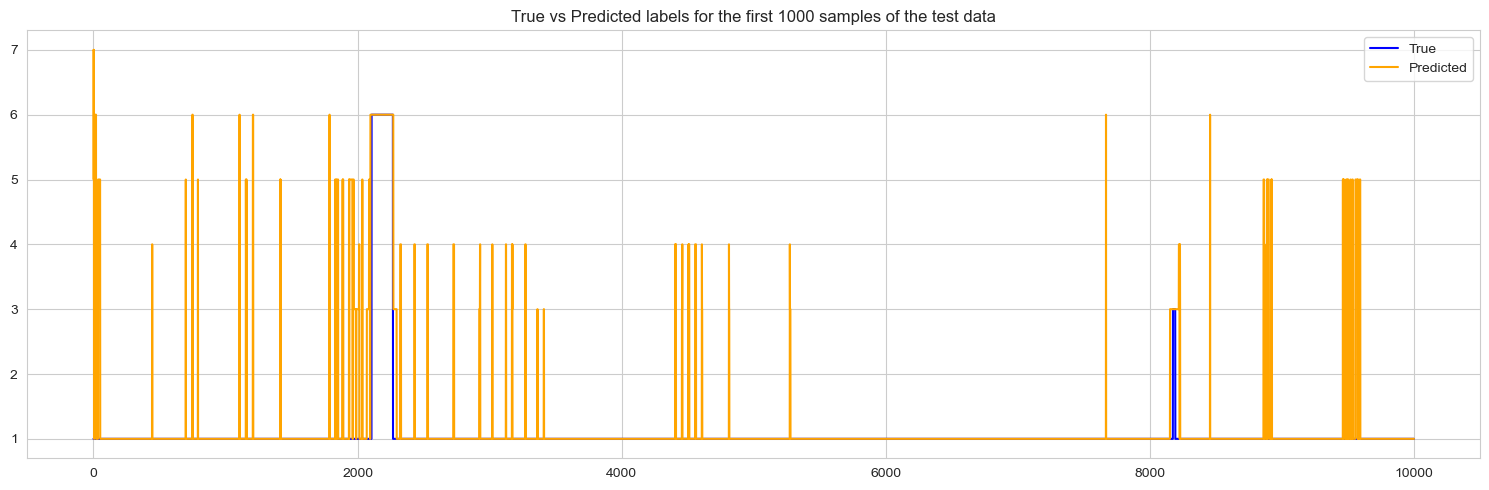

In [14]:
# Now we can evaluate the accuracy of the ESN on the test data
# Start by plotting the true label and the predicted label on a graph

y_test_decoded = data_preparation.get_decoded_labels('test')

plt.figure(figsize=(15, 5))
plt.plot(y_test_decoded[:10000], label='True', color='blue')
plt.plot(y_pred_decoded[:10000], label='Predicted', color='orange')
plt.legend()
plt.title('True vs Predicted labels for the first 1000 samples of the test data')

plt.tight_layout()
plt.show()

In [15]:
# Now we can calculate the accuracy of the ESN on the test data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_decoded, y_pred_decoded)

accuracy

0.6556714372310225

In [16]:
# Now we can calculate the confusion matrix for the ESN on the test data
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

conf_matrix

array([[227577,  51202,   7876,  42813,  17045,     62,      6],
       [   370,  12648,    225,   3563,   2833,      1,      0],
       [   303,    256,   1634,    471,     44,      0,      0],
       [    31,     54,     20,    264,      1,      0,      0],
       [   353,  58176,     88,   5845,  77330,      4,      0],
       [    40,     19,    117,   1869,      1,  41158,      0],
       [     0,      3,      0,     10,      0,      0,   8235]],
      dtype=int64)

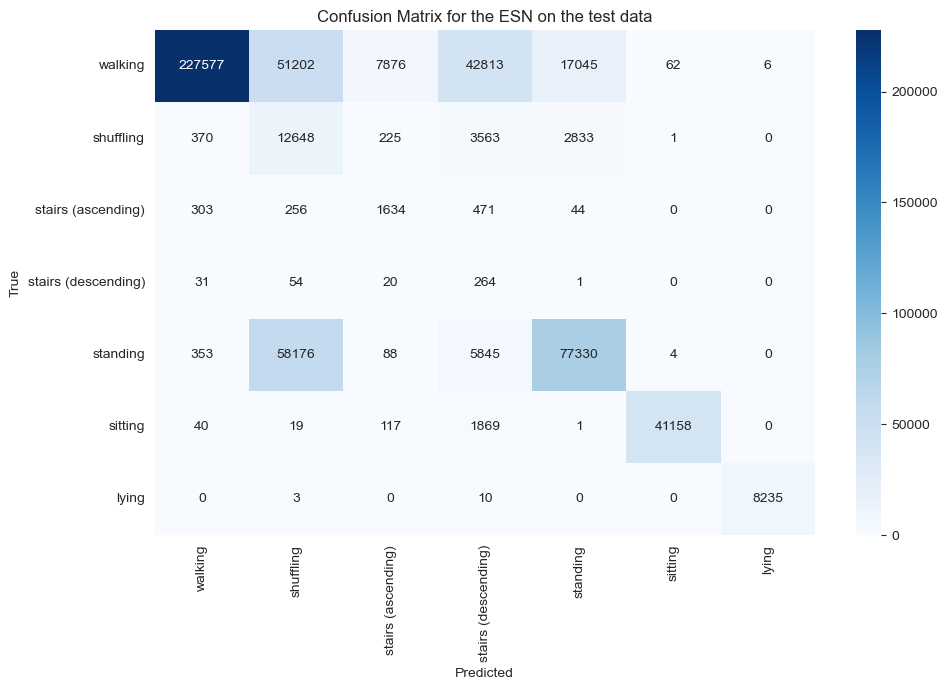

In [17]:
# Now we can plot the confusion matrix
# Our labels are 
# 1: walking	
# 3: shuffling
# 4: stairs (ascending)
# 5: stairs (descending)
# 6: standing
# 7: sitting
# 8: lying
# So we will use these labels for the x and y axis of the confusion matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()


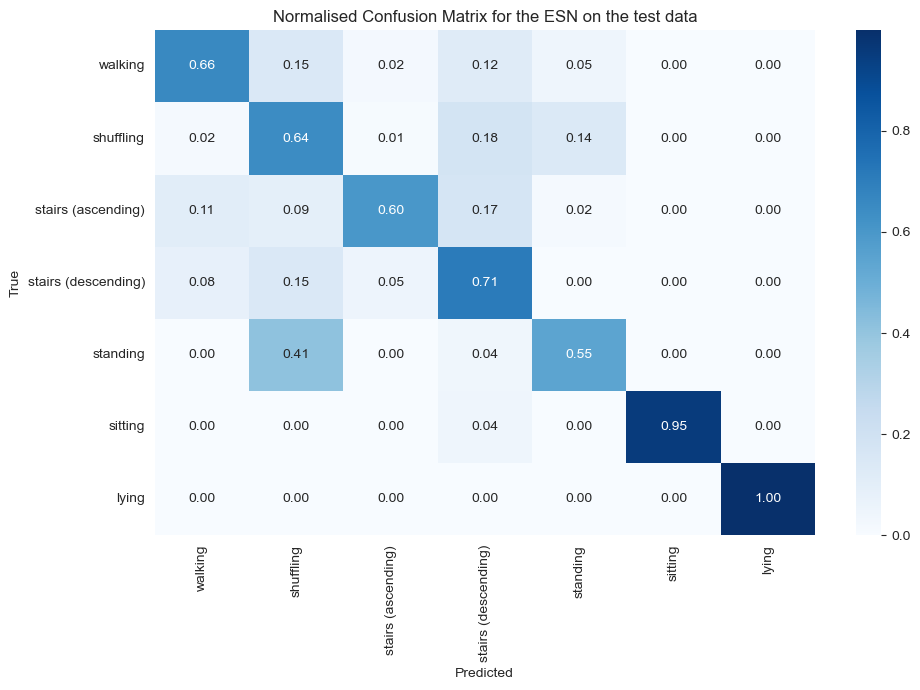

In [18]:
# Let's print a normalised confusion matrix as there is a class imbalance
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Normalised Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()

In [19]:
# Now we can calculate the precision, recall and f1-score for the ESN on the test data
from sklearn.metrics import classification_report

report = classification_report(y_test_decoded, y_pred_decoded, target_names=labels)

print(report)

                     precision    recall  f1-score   support

            walking       1.00      0.66      0.79    346581
          shuffling       0.10      0.64      0.18     19640
 stairs (ascending)       0.16      0.60      0.26      2708
stairs (descending)       0.00      0.71      0.01       370
           standing       0.80      0.55      0.65    141796
            sitting       1.00      0.95      0.97     43204
              lying       1.00      1.00      1.00      8248

           accuracy                           0.66    562547
          macro avg       0.58      0.73      0.55    562547
       weighted avg       0.91      0.66      0.75    562547



In [20]:
# We can see that this is already performing quite well with the two reservoirs using different hyperparameters
# Let's try and optimise this further by using hyperopt to find the best hyperparameters for the ESN
# We will start by defining the hyperparameter space
from hyperopt import hp
from sklearn.metrics import mean_squared_error

total_neurons = 500

weight_distribution_options = ['uniform', 'normal', '0/1', '-1/1']

space = {
    'leakage_rate_1': hp.uniform('leakage_rate_1', 0, 1),
    'spectral_radius_1': hp.uniform('spectral_radius_1', 0, 1),
    'gamma_1': hp.uniform('gamma_1', 0, 1),
    'density_1': hp.uniform('density_1', 0, 1),

    'leakage_rate_2': hp.uniform('leakage_rate_2', 0, 1),
    'spectral_radius_2': hp.uniform('spectral_radius_2', 0, 1),
    'gamma_2': hp.uniform('gamma_2', 0, 1),
    'density_2': hp.uniform('density_2', 0, 1),

    # The number of neurons should be between 100 and 500, and n_neurons_1 + n_neurons_2 = 500
    # The upper bound is set to the total - 100 to ensure that each reservoir has at least 100 neurons
    'n_neurons_1': hp.choice('n_neurons_1', [100, 200, 300, 400]),
    # We will set n_neurons_2 = 500 - n_neurons_1

    'weight_distribution_1': hp.choice('weight_distribution_1', weight_distribution_options),
    'weight_distribution_2': hp.choice('weight_distribution_2', weight_distribution_options),
}

# We will also define the objective function
from hyperopt import STATUS_OK


def objective(params):
    # Generate the input weights
    n_features = 6
    
    n_neurons_1 = params['n_neurons_1']
    n_neurons_2 = total_neurons - n_neurons_1
    
    print(f'n_neurons_1: {n_neurons_1}, n_neurons_2: {n_neurons_2}')

    input_weights_1 = generate_input_weights(n_neurons_1, n_features, params['density_1'],
                                             params['weight_distribution_1'], seed=42)
    input_weights_2 = generate_input_weights(n_neurons_2, n_features, params['density_2'],
                                             params['weight_distribution_2'], seed=42)


    # Create the ESN
    esn = HierarchyESN(leakage_rate_1=params['leakage_rate_1'], spectral_radius_1=params['spectral_radius_1'],
                       gamma_1=params['gamma_1'], W_in_1=input_weights_1, n_neurons_1=n_neurons_1,
                       leakage_rate_2=params['leakage_rate_2'], spectral_radius_2=params['spectral_radius_2'],
                       gamma_2=params['gamma_2'], W_in_2=input_weights_2, n_neurons_2=n_neurons_2,
                       class_weights=class_weights, seed=42, is_optimising=True)

    # Fit the ESN
    esn.fit(data_in, data_out, x_val=X_val_scaled, y_val=y_val_encoded)

    # Predict the output
    y_pred = esn.forward(X_test_scaled)

    # Decode the output
    y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

    # Calculate the nmrse
    nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_pred_decoded.max() - y_pred_decoded.min())

    return {'loss': nmrse, 'status': STATUS_OK}

In [21]:
run_hierarchy_optimisation = False

In [22]:
# Now we can run the hyperparameter optimisation
if run_hierarchy_optimisation:
    from hyperopt import fmin, tpe, Trials

    n_iterations = 50

    trials = Trials()

    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=n_iterations, trials=trials)

else:
    best = {'density_1': 0.7983216917715843, 'density_2': 0.010877135881297934, 'gamma_1': 0.9634809164294149, 'gamma_2': 0.7797466776214464, 'leakage_rate_1': 0.9318915931720418, 'leakage_rate_2': 0.35101073644620073, 'n_neurons_1': 3, 'spectral_radius_1': 0.9819903553570943, 'spectral_radius_2': 0.1404437385565157, 'weight_distribution_1': 0, 'weight_distribution_2': 2}

In [23]:
print(best)

{'density_1': 0.7983216917715843, 'density_2': 0.010877135881297934, 'gamma_1': 0.9634809164294149, 'gamma_2': 0.7797466776214464, 'leakage_rate_1': 0.9318915931720418, 'leakage_rate_2': 0.35101073644620073, 'n_neurons_1': 3, 'spectral_radius_1': 0.9819903553570943, 'spectral_radius_2': 0.1404437385565157, 'weight_distribution_1': 0, 'weight_distribution_2': 2}


In [24]:
# Let's get the best hyperparameters
best_leakage_rate_1 = best['leakage_rate_1']
best_spectral_radius_1 = best['spectral_radius_1']
best_gamma_1 = best['gamma_1']
best_density_1 = best['density_1']

best_leakage_rate_2 = best['leakage_rate_2']
best_spectral_radius_2 = best['spectral_radius_2']
best_gamma_2 = best['gamma_2']
best_density_2 = best['density_2']

neuron_opts = [100, 200, 300, 400]

best_n_neurons_1 = neuron_opts[best['n_neurons_1']]
best_n_neurons_2 = total_neurons - best_n_neurons_1

best_weight_distribution_1 = weight_distribution_options[best['weight_distribution_1']]
best_weight_distribution_2 = weight_distribution_options[best['weight_distribution_2']]

In [25]:
print(f'Best Neurons 1: {best_n_neurons_1}, Best Neurons 2: {best_n_neurons_2}')
print(f'Best Density 1: {best_density_1}, Best Density 2: {best_density_2}')
print(f'Best Leakage Rate 1: {best_leakage_rate_1}, Best Leakage Rate 2: {best_leakage_rate_2}')
print(f'Best Spectral Radius 1: {best_spectral_radius_1}, Best Spectral Radius 2: {best_spectral_radius_2}')
print(f'Best Gamma 1: {best_gamma_1}, Best Gamma 2: {best_gamma_2}')
print(f'Best Weight Distribution 1: {best_weight_distribution_1}, Best Weight Distribution 2: {best_weight_distribution_2}')

Best Neurons 1: 400, Best Neurons 2: 100
Best Density 1: 0.7983216917715843, Best Density 2: 0.010877135881297934
Best Leakage Rate 1: 0.9318915931720418, Best Leakage Rate 2: 0.35101073644620073
Best Spectral Radius 1: 0.9819903553570943, Best Spectral Radius 2: 0.1404437385565157
Best Gamma 1: 0.9634809164294149, Best Gamma 2: 0.7797466776214464
Best Weight Distribution 1: uniform, Best Weight Distribution 2: 0/1


In [26]:
# Now we can create the ESN with the best hyperparameters
# If we are running the optimisation, or the pickle file does not exist, we will create the ESN with the best hyperparameters
# Otherwise, we will load the ESN from the pickle file

optimised_pickle = 'hierarchyESN_har70_optimised.pkl'

if run_hierarchy_optimisation or not os.path.exists(optimised_pickle):
    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2,
                                             seed=42)

    esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                       gamma_1=best_gamma_1,
                       W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                       leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                       gamma_2=best_gamma_2,
                       W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                       class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(data_in, data_out, x_val=X_val_scaled, y_val=y_val_encoded)

    # Let's also pickle the best ESN for future use
    with open(optimised_pickle, 'wb') as f:
        pickle.dump(esn, f)

else:
    # Load the ESN from the pickle file
    with open(optimised_pickle, 'rb') as f:
        esn = pickle.load(f)


[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 1357646/1357646 [14:32<00:00, 1555.56it/s]


Shape of previous_states: (1357646, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 339404/339404 [03:39<00:00, 1547.40it/s]


Shape of previous_states: (339404, 500)
Alpha: 1e-05, Score: 0.255216754160426
Alpha: 7.742636826811278e-05, Score: 0.27851352927422957
Alpha: 0.0005994842503189409, Score: 0.2979230095760644
Alpha: 0.004641588833612777, Score: 0.30272572824919564
Alpha: 0.03593813663804626, Score: 0.29553221746223357
Alpha: 0.2782559402207126, Score: 0.281795710598665


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.55114e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.25327405013011406
Alpha: 16.681005372000556, Score: 0.20440161327216375
Alpha: 129.15496650148827, Score: 0.14569124533050895
Alpha: 1000.0, Score: 0.1037689562039897
Best alpha: 0.004641588833612777
Readout layer fitted.


In [27]:
# Predict the output
y_pred = esn.forward(X_test_scaled)

# Decode the output
y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_pred_decoded.max() - y_pred_decoded.min())

print(f'Optimised NMRSE: {nmrse}')

100%|██████████| 562547/562547 [06:05<00:00, 1540.15it/s]


Shape of previous_states: (562547, 500)
Optimised NMRSE: 0.21880821196075534


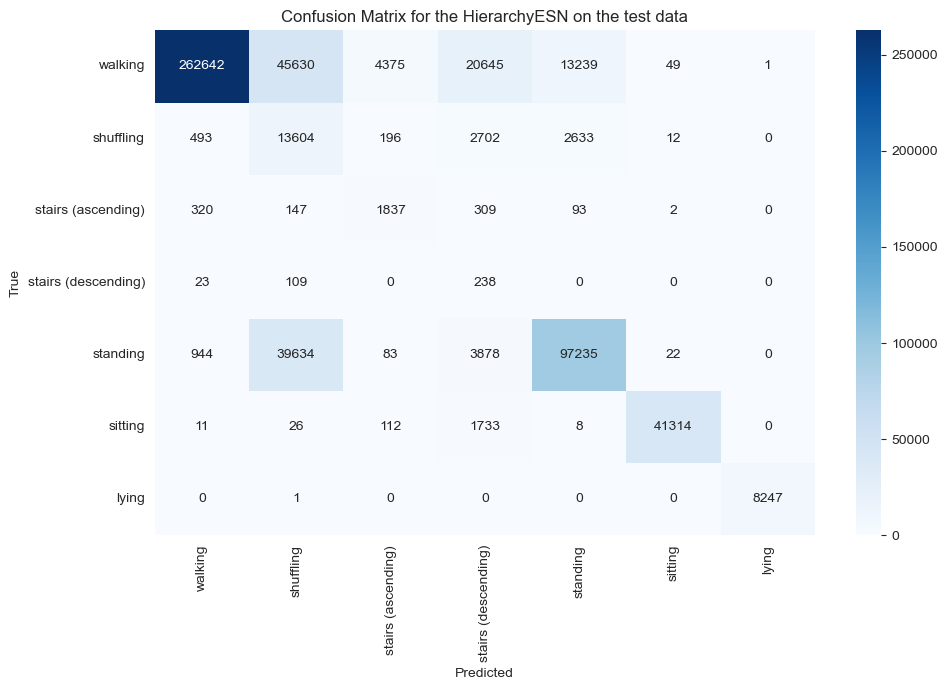

In [28]:
# Let's plot the confusion matrix for the best ESN
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for the HierarchyESN on the test data')

plt.tight_layout()
plt.show()

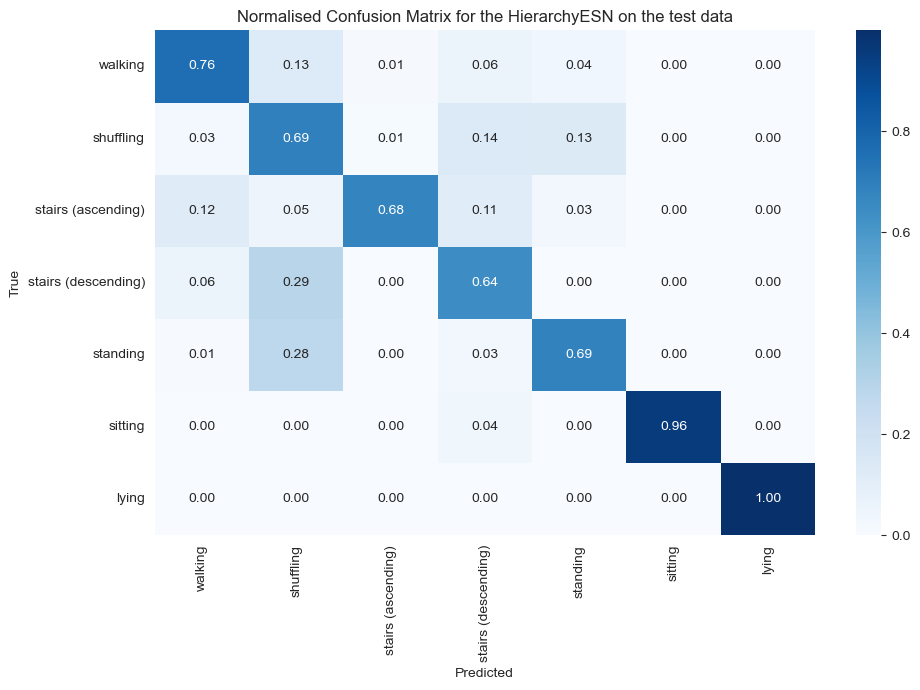

In [29]:
# Let's plot the normalised confusion matrix for the best ESN
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Normalised Confusion Matrix for the HierarchyESN on the test data')

plt.tight_layout()
plt.show()

In [30]:
# Let's print the classification report for the best ESN
report = classification_report(y_test_decoded, y_pred_decoded, target_names=labels)

print(report)

                     precision    recall  f1-score   support

            walking       0.99      0.76      0.86    346581
          shuffling       0.14      0.69      0.23     19640
 stairs (ascending)       0.28      0.68      0.39      2708
stairs (descending)       0.01      0.64      0.02       370
           standing       0.86      0.69      0.76    141796
            sitting       1.00      0.96      0.98     43204
              lying       1.00      1.00      1.00      8248

           accuracy                           0.76    562547
          macro avg       0.61      0.77      0.61    562547
       weighted avg       0.93      0.76      0.82    562547



In [31]:
# Let's also try applying some of the preprocessing techniques used in prior experiments to see if we can improve the performance of the ESN further
data_preprocessor = DataPreprocessor()

# The data preprocessor object provides access to different data preprocessing methods
# The available methods are:
# - buffered_windows(window_size, x, y)
# - exponential_moving_average(alpha, x, y)
# - fourier_smoothing(x, threshold)
# - pipeline(step_names, x, y)
# - get_available_steps()

In [68]:
run_window_optimisation = False

In [69]:
# Let's start by applying the buffered windows method to the data
# For these experiments, we will use the previously found best hyperparameters above

window_sizes = [10, 50, 100, 500]

window_scores = []

if run_window_optimisation:
    for window_size in window_sizes:
        print(f'Window Size: {window_size}')
        X_train_windowed, y_train_windowed = data_preprocessor.buffered_windows(window_size, X_train_scaled,
                                                                                y_train_encoded)
        X_val_windowed, y_val_windowed = data_preprocessor.buffered_windows(window_size, X_val_scaled, y_val_encoded)
        X_test_windowed, y_test_windowed = data_preprocessor.buffered_windows(window_size, X_test_scaled,
                                                                              y_test_encoded)
        
        # As the windowed data is now in a different shape, we need to regenerate the input weights
        input_weights_1 = generate_input_weights(best_n_neurons_1, X_train_windowed.shape[1], best_density_1, best_weight_distribution_1,
                                                 seed=42)
        input_weights_2 = generate_input_weights(best_n_neurons_2, X_train_windowed.shape[1], best_density_2, best_weight_distribution_2,
                                                    seed=42)

        esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                           gamma_1=best_gamma_1,
                           W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                           leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                           gamma_2=best_gamma_2,
                           W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                           class_weights=class_weights, seed=42)

        # Fit the ESN
        esn.fit(X_train_windowed, y_train_windowed, x_val=X_val_windowed, y_val=y_val_windowed)

        # Predict the output
        y_pred = esn.forward(X_test_windowed)

        # Decode the output
        # We need to decode the output as it is one-hot encoded
        # But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
        y_test_resized = y_test_windowed.reshape(-1, y_test_windowed.shape[-1] // window_size)
        y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1] // window_size)

        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_resized)
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_resized)

        # Calculate the nmrse
        nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_pred_decoded.max() - y_pred_decoded.min())

        window_scores.append({'window_size': window_size, 'nmrse': nmrse})

        print(f'Window Size: {window_size}, NMRSE: {nmrse}')

else:
    window_scores = [{'window_size': 10, 'nmrse': 0.27056676178990535}, {'window_size': 50, 'nmrse': 0.32112943235368896}, {'window_size': 100, 'nmrse': 0.3492934064096462}, {'window_size': 500, 'nmrse': 0.4580430745580356}]

In [70]:
print(window_scores)

[{'window_size': 10, 'nmrse': 0.27056676178990535}, {'window_size': 50, 'nmrse': 0.32112943235368896}, {'window_size': 100, 'nmrse': 0.3492934064096462}, {'window_size': 500, 'nmrse': 0.4580430745580356}]


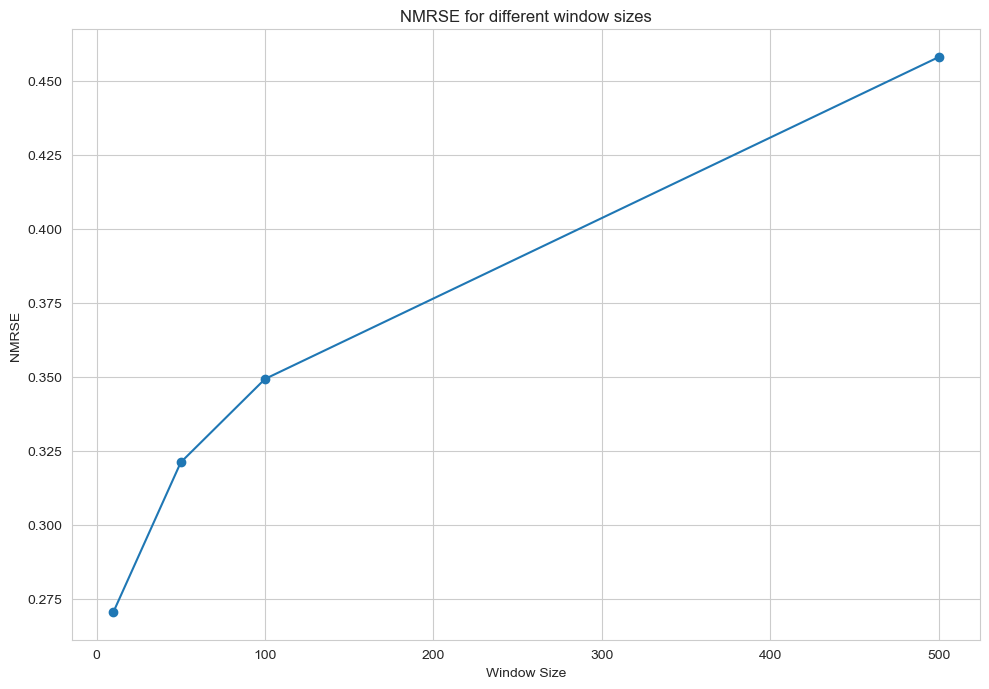

In [71]:
# Let's plot the NMRSE for the different window sizes
sizes = [score['window_size'] for score in window_scores]
nmrses = [score['nmrse'] for score in window_scores]

plt.figure(figsize=(10, 7))

plt.plot(sizes, nmrses, marker='o')

plt.xlabel('Window Size')
plt.ylabel('NMRSE')

plt.title('NMRSE for different window sizes')

plt.tight_layout()
plt.show()

In [72]:
# Get the best window size
best_window_size = window_scores[np.argmin(nmrses)]['window_size']

print(f'Best Window Size: {best_window_size}')

Best Window Size: 10


In [73]:
run_emas_optimisation = False

In [74]:
# Let's try applying the exponential moving average smoothing method to the data
# For these experiments, we will use the previously found best hyperparameters above

alphas = [0.001, 0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]

ema_scores = []

if run_emas_optimisation:
    for alpha in alphas:
        print(f'Alpha: {alpha}')
        X_train_ema, y_train_ema = data_preprocessor.exponential_moving_average(alpha, X_train_scaled, y_train_encoded)
        X_val_ema, y_val_ema = data_preprocessor.exponential_moving_average(alpha, X_val_scaled, y_val_encoded)
        X_test_ema, y_test_ema = data_preprocessor.exponential_moving_average(alpha, X_test_scaled, y_test_encoded)
        
        input_weights_1 = generate_input_weights(best_n_neurons_1, X_train_ema.shape[1], best_density_1, best_weight_distribution_1,
                                                    seed=42)
        input_weights_2 = generate_input_weights(best_n_neurons_2, X_train_ema.shape[1], best_density_2, best_weight_distribution_2,
                                                    seed=42)

        esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                           gamma_1=best_gamma_1,
                           W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                           leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                           gamma_2=best_gamma_2,
                           W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                           class_weights=class_weights, seed=42)

        # Fit the ESN
        esn.fit(X_train_ema, y_train_ema, x_val=X_val_ema, y_val=y_val_ema)

        # Predict the output
        y_pred = esn.forward(X_test_ema)

        # Decode the output
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_ema)
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

        # Calculate the nmrse
        nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_pred_decoded.max() - y_pred_decoded.min())

        ema_scores.append({'alpha': alpha, 'nmrse': nmrse})

        print(f'Alpha: {alpha}, NMRSE: {nmrse}')

else:
    ema_scores = [{'alpha': 0.001, 'nmrse': 0.21918599009522355}, {'alpha': 0.01, 'nmrse': 0.2190269570895608}, {'alpha': 0.1, 'nmrse': 0.2180522727264078}, {'alpha': 0.5, 'nmrse': 0.21563822149836329}, {'alpha': 0.7, 'nmrse': 0.21612756997739171}, {'alpha': 0.8, 'nmrse': 0.21691179370149755}, {'alpha': 0.9, 'nmrse': 0.21774293109895565}, {'alpha': 0.95, 'nmrse': 0.2182485053103225}, {'alpha': 0.99, 'nmrse': 0.21866151370973386}, {'alpha': 0.999, 'nmrse': 0.21875224769503973}]

In [75]:
print(ema_scores)

[{'alpha': 0.001, 'nmrse': 0.21918599009522355}, {'alpha': 0.01, 'nmrse': 0.2190269570895608}, {'alpha': 0.1, 'nmrse': 0.2180522727264078}, {'alpha': 0.5, 'nmrse': 0.21563822149836329}, {'alpha': 0.7, 'nmrse': 0.21612756997739171}, {'alpha': 0.8, 'nmrse': 0.21691179370149755}, {'alpha': 0.9, 'nmrse': 0.21774293109895565}, {'alpha': 0.95, 'nmrse': 0.2182485053103225}, {'alpha': 0.99, 'nmrse': 0.21866151370973386}, {'alpha': 0.999, 'nmrse': 0.21875224769503973}]


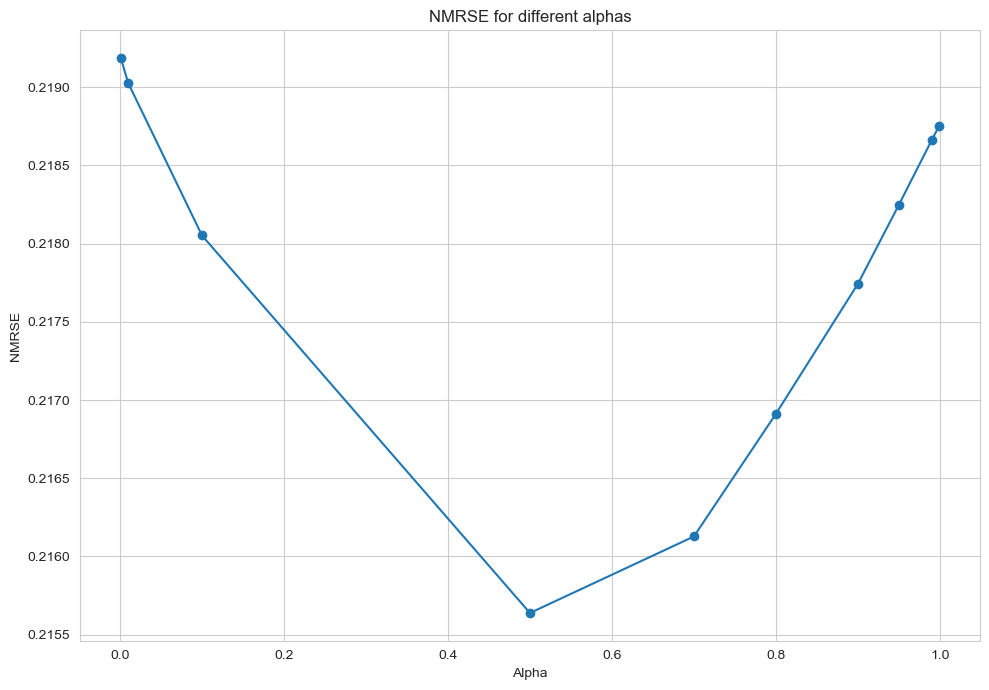

In [76]:
# Let's plot the NMRSE for the different alphas
alphas = [score['alpha'] for score in ema_scores]
nmrses = [score['nmrse'] for score in ema_scores]

plt.figure(figsize=(10, 7))

plt.plot(alphas, nmrses, marker='o')

plt.xlabel('Alpha')
plt.ylabel('NMRSE')

plt.title('NMRSE for different alphas')

plt.tight_layout()
plt.show()

In [77]:
# Get the best alpha
best_alpha = ema_scores[np.argmin(nmrses)]['alpha']

print(f'Best Alpha: {best_alpha}')

Best Alpha: 0.5


In [78]:
run_fourier_optimisation = False

In [79]:
# Let's try applying the fourier smoothing method to the data
# For these experiments, we will use the previously found best hyperparameters above

thresholds = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

fourier_scores = []

if run_fourier_optimisation:
    for threshold in thresholds:
        print(f'Threshold: {threshold}')
        X_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, threshold)
        X_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, threshold)
        X_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, threshold)
        
        input_weights_1 = generate_input_weights(best_n_neurons_1, X_train_fourier.shape[1], best_density_1, best_weight_distribution_1,
                                                    seed=42)
        input_weights_2 = generate_input_weights(best_n_neurons_2, X_train_fourier.shape[1], best_density_2, best_weight_distribution_2,
                                                    seed=42)

        esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                           gamma_1=best_gamma_1,
                           W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                           leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                           gamma_2=best_gamma_2,
                           W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                           class_weights=class_weights, seed=42)

        # Fit the ESN
        esn.fit(X_train_fourier, y_train_encoded, x_val=X_val_fourier, y_val=y_val_encoded)

        # Predict the output
        y_pred = esn.forward(X_test_fourier)

        # Decode the output
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

        # Calculate the nmrse
        nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_pred_decoded.max() - y_pred_decoded.min())

        fourier_scores.append({'threshold': threshold, 'nmrse': nmrse})

        print(f'Threshold: {threshold}, NMRSE: {nmrse}')

else:
    fourier_scores = [{'threshold': 1000.0, 'nmrse': 0.21866748639082298}, {'threshold': 100.0, 'nmrse': 0.21866748639082298}, {'threshold': 10.0, 'nmrse': 0.21866748639082298}, {'threshold': 1.0, 'nmrse': 0.21866748639082298}, {'threshold': 0.1, 'nmrse': 0.20905066524544752}, {'threshold': 0.01, 'nmrse': 0.3024791465706963}, {'threshold': 0.001, 'nmrse': 0.3860562745934209}, {'threshold': 0.0001, 'nmrse': 0.44332478639797934}, {'threshold': 1e-05, 'nmrse': 0.46651425248024475}]

In [80]:
print(fourier_scores)

[{'threshold': 1000.0, 'nmrse': 0.21866748639082298}, {'threshold': 100.0, 'nmrse': 0.21866748639082298}, {'threshold': 10.0, 'nmrse': 0.21866748639082298}, {'threshold': 1.0, 'nmrse': 0.21866748639082298}, {'threshold': 0.1, 'nmrse': 0.20905066524544752}, {'threshold': 0.01, 'nmrse': 0.3024791465706963}, {'threshold': 0.001, 'nmrse': 0.3860562745934209}, {'threshold': 0.0001, 'nmrse': 0.44332478639797934}, {'threshold': 1e-05, 'nmrse': 0.46651425248024475}]


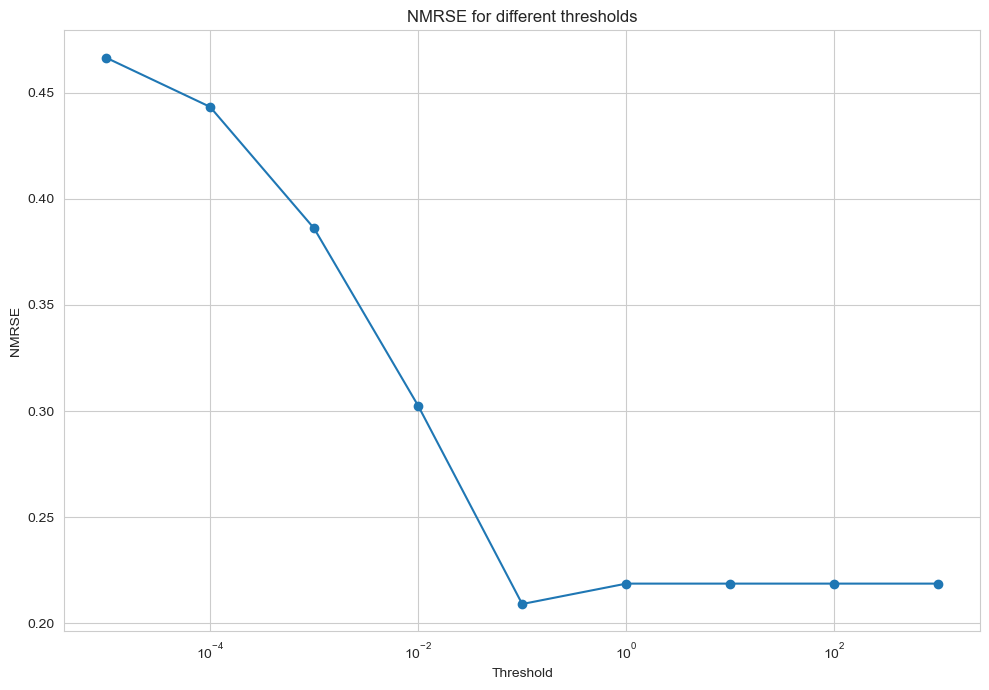

In [81]:
# Let's plot the NMRSE for the different thresholds
thresholds = [score['threshold'] for score in fourier_scores]
nmrses = [score['nmrse'] for score in fourier_scores]

plt.figure(figsize=(10, 7))

plt.plot(thresholds, nmrses, marker='o')

plt.xlabel('Threshold')
plt.ylabel('NMRSE')
plt.xscale('log')

plt.title('NMRSE for different thresholds')

plt.tight_layout()
plt.show()

In [82]:
# Get the best threshold
best_threshold = fourier_scores[np.argmin(nmrses)]['threshold']

print(f'Best Threshold: {best_threshold}')

Best Threshold: 0.1


In [83]:
run_fourier_window_optimisation = False

In [84]:
# As with the previous baselines, we will apply the fourier smoothing method followed by the buffered windows method

window_sizes = [10, 50, 100, 500]
thresholds = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

pipeline_steps = ['fourier_smoothing', 'buffered_windows']

fourier_window_scores = []

if run_fourier_window_optimisation:
    for threshold in thresholds:
        for window_size in window_sizes:
            print(f'Threshold: {threshold}, Window Size: {window_size}')

            pipeline_params = [threshold, window_size]

            x_train_windowed_fourier, y_train_windowed_fourier = data_preprocessor.pipeline(pipeline_steps,
                                                                                            X_train_scaled,
                                                                                            y_train_encoded,
                                                                                            pipeline_params)

            x_val_windowed_fourier, y_val_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_val_scaled,
                                                                                        y_val_encoded, pipeline_params)

            x_test_windowed_fourier, y_test_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_test_scaled,
                                                                                          y_test_encoded,
                                                                                          pipeline_params)
            
            input_weights_1 = generate_input_weights(best_n_neurons_1, x_train_windowed_fourier.shape[1], best_density_1, best_weight_distribution_1,
                                                    seed=42)
            
            input_weights_2 = generate_input_weights(best_n_neurons_2, x_train_windowed_fourier.shape[1], best_density_2, best_weight_distribution_2,
                                                    seed=42)

            esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                               gamma_1=best_gamma_1,
                               W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                               leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                               gamma_2=best_gamma_2,
                               W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                               class_weights=class_weights, seed=42)

            # Fit the ESN
            esn.fit(x_train_windowed_fourier, y_train_windowed_fourier, x_val=x_val_windowed_fourier,
                    y_val=y_val_windowed_fourier)

            # Predict the output
            y_pred = esn.forward(x_test_windowed_fourier)

            # Decode the output
            # We need to decode the output as it is one-hot encoded
            # But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
            y_test_resized = y_test_windowed_fourier.reshape(-1, y_test_windowed_fourier.shape[-1] // window_size)
            y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1] // window_size)

            y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_resized)
            y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_resized)

            # Calculate the nmrse
            nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                        y_pred_decoded.max() - y_pred_decoded.min())

            fourier_window_scores.append({'threshold': threshold, 'window_size': window_size, 'nmrse': nmrse})

            print(f'Threshold: {threshold}, Window Size: {window_size}, NMRSE: {nmrse}')

else:
    fourier_window_scores = [{'threshold': 1000.0, 'window_size': 10, 'nmrse': 0.27105772446373216}, {'threshold': 1000.0, 'window_size': 50, 'nmrse': 0.3228216121034252}, {'threshold': 1000.0, 'window_size': 100, 'nmrse': 0.3478208521186858}, {'threshold': 1000.0, 'window_size': 500, 'nmrse': 0.45794960215306907}, {'threshold': 100.0, 'window_size': 10, 'nmrse': 0.27105772446373216}, {'threshold': 100.0, 'window_size': 50, 'nmrse': 0.3228216121034252}, {'threshold': 100.0, 'window_size': 100, 'nmrse': 0.3478208521186858}, {'threshold': 100.0, 'window_size': 500, 'nmrse': 0.45794960215306907}, {'threshold': 10.0, 'window_size': 10, 'nmrse': 0.27105772446373216}, {'threshold': 10.0, 'window_size': 50, 'nmrse': 0.3228216121034252}, {'threshold': 10.0, 'window_size': 100, 'nmrse': 0.3478208521186858}, {'threshold': 10.0, 'window_size': 500, 'nmrse': 0.45794960215306907}, {'threshold': 1.0, 'window_size': 10, 'nmrse': 0.27105772446373216}, {'threshold': 1.0, 'window_size': 50, 'nmrse': 0.3228216121034252}, {'threshold': 1.0, 'window_size': 100, 'nmrse': 0.3478208521186858}, {'threshold': 1.0, 'window_size': 500, 'nmrse': 0.45794960215306907}, {'threshold': 0.1, 'window_size': 10, 'nmrse': 0.22883054436921355}, {'threshold': 0.1, 'window_size': 50, 'nmrse': 0.2994800188268817}, {'threshold': 0.1, 'window_size': 100, 'nmrse': 0.3448593523387781}, {'threshold': 0.1, 'window_size': 500, 'nmrse': 0.4773417150380885}, {'threshold': 0.01, 'window_size': 10, 'nmrse': 0.30166101330747924}, {'threshold': 0.01, 'window_size': 50, 'nmrse': 0.33291824252016283}, {'threshold': 0.01, 'window_size': 100, 'nmrse': 0.3443183718849824}, {'threshold': 0.01, 'window_size': 500, 'nmrse': 0.4681384270003676}, {'threshold': 0.001, 'window_size': 10, 'nmrse': 0.3395529420111725}, {'threshold': 0.001, 'window_size': 50, 'nmrse': 0.3390292341182896}, {'threshold': 0.001, 'window_size': 100, 'nmrse': 0.3734974589804914}, {'threshold': 0.001, 'window_size': 500, 'nmrse': 0.4670855985710796}, {'threshold': 0.0001, 'window_size': 10, 'nmrse': 0.4303531324592438}, {'threshold': 0.0001, 'window_size': 50, 'nmrse': 0.4086683346492367}, {'threshold': 0.0001, 'window_size': 100, 'nmrse': 0.41317212195671}, {'threshold': 0.0001, 'window_size': 500, 'nmrse': 0.4678511043228874}, {'threshold': 1e-05, 'window_size': 10, 'nmrse': 0.5389181307551666}, {'threshold': 1e-05, 'window_size': 50, 'nmrse': 0.48917114482719826}, {'threshold': 1e-05, 'window_size': 100, 'nmrse': 0.5107993591483019}, {'threshold': 1e-05, 'window_size': 500, 'nmrse': 0.5316550061732758}]

In [85]:
print(fourier_window_scores)

[{'threshold': 1000.0, 'window_size': 10, 'nmrse': 0.27105772446373216}, {'threshold': 1000.0, 'window_size': 50, 'nmrse': 0.3228216121034252}, {'threshold': 1000.0, 'window_size': 100, 'nmrse': 0.3478208521186858}, {'threshold': 1000.0, 'window_size': 500, 'nmrse': 0.45794960215306907}, {'threshold': 100.0, 'window_size': 10, 'nmrse': 0.27105772446373216}, {'threshold': 100.0, 'window_size': 50, 'nmrse': 0.3228216121034252}, {'threshold': 100.0, 'window_size': 100, 'nmrse': 0.3478208521186858}, {'threshold': 100.0, 'window_size': 500, 'nmrse': 0.45794960215306907}, {'threshold': 10.0, 'window_size': 10, 'nmrse': 0.27105772446373216}, {'threshold': 10.0, 'window_size': 50, 'nmrse': 0.3228216121034252}, {'threshold': 10.0, 'window_size': 100, 'nmrse': 0.3478208521186858}, {'threshold': 10.0, 'window_size': 500, 'nmrse': 0.45794960215306907}, {'threshold': 1.0, 'window_size': 10, 'nmrse': 0.27105772446373216}, {'threshold': 1.0, 'window_size': 50, 'nmrse': 0.3228216121034252}, {'threshol

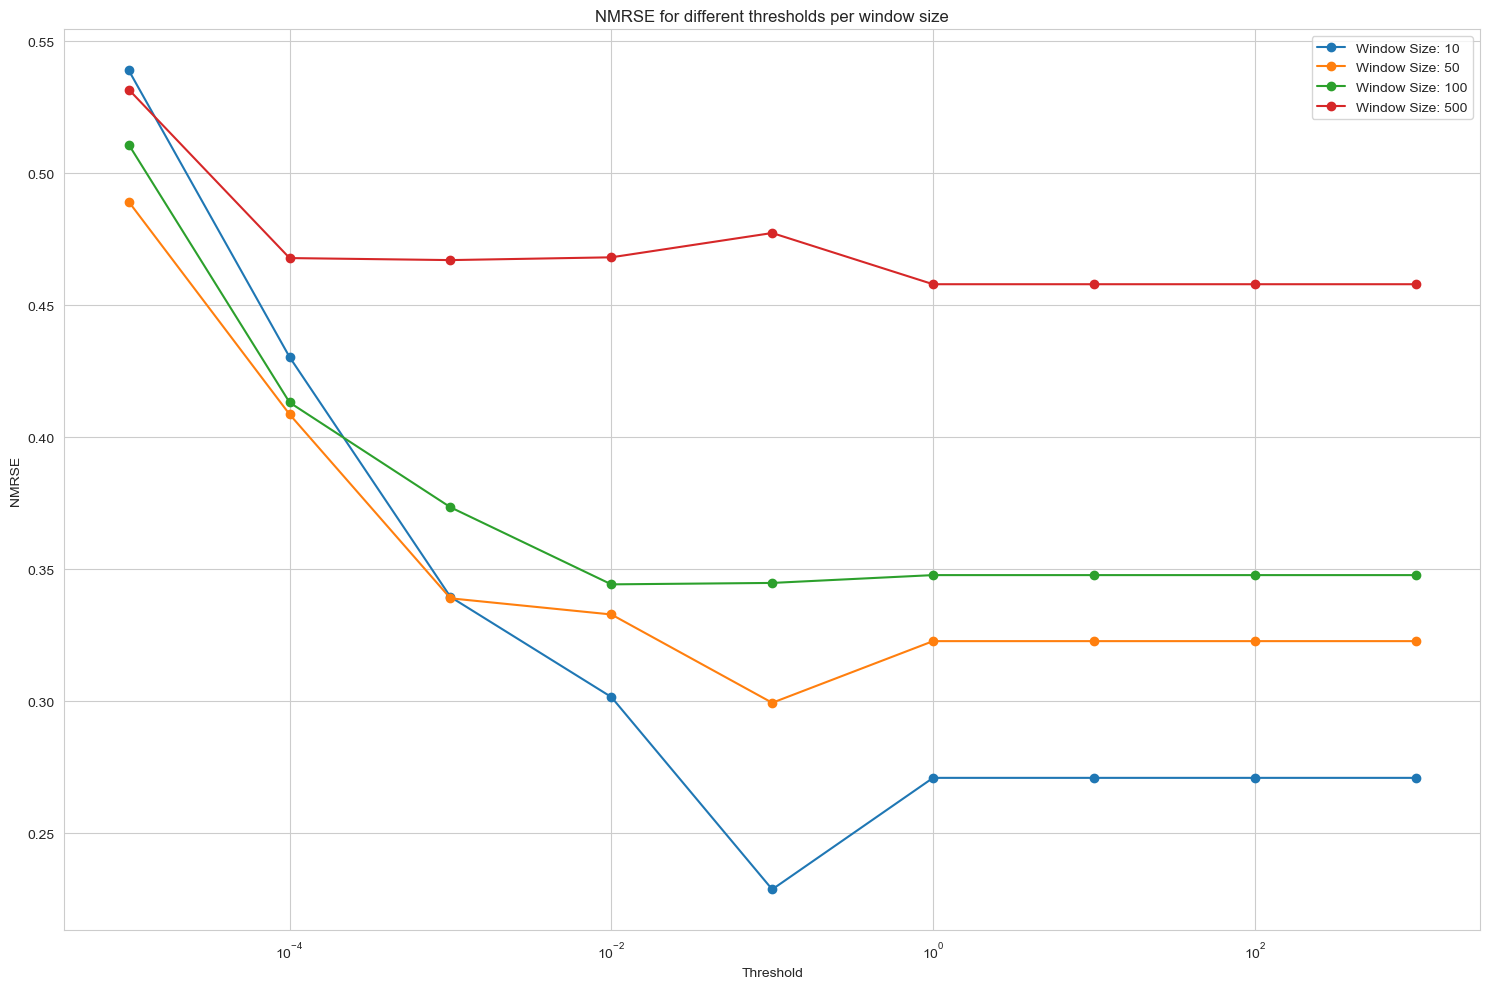

In [86]:
# Let's plot the NMRSE for the different thresholds per window size
# The results are in an array of dictionaries, so we need to extract the data into a format that can be plotted
# We will create a dictionary where the keys are the window sizes, and the values are the NMRSEs for the different thresholds

window_scores_dict = {window_size: [] for window_size in window_sizes}

for score in fourier_window_scores:
    window_size = score['window_size']
    threshold = score['threshold']
    nmrse = score['nmrse']

    window_scores_dict[window_size].append({'threshold': threshold, 'nmrse': nmrse})

# Now we can plot the NMRSE for the different thresholds per window size
plt.figure(figsize=(15, 10))

for window_size, scores in window_scores_dict.items():
    thresholds = [score['threshold'] for score in scores]
    nmrses = [score['nmrse'] for score in scores]

    plt.plot(thresholds, nmrses, marker='o', label=f'Window Size: {window_size}')

plt.xlabel('Threshold')
plt.ylabel('NMRSE')
plt.xscale('log')
plt.legend()

plt.title('NMRSE for different thresholds per window size')

plt.tight_layout()
plt.show()

In [87]:
# Get the best threshold and window size
best_threshold_window = fourier_window_scores[np.argmin([score['nmrse'] for score in fourier_window_scores])]
best_threshold = best_threshold_window['threshold']
best_window_size = best_threshold_window['window_size']

print(f'Best Threshold: {best_threshold}, Best Window Size: {best_window_size}')

Best Threshold: 0.1, Best Window Size: 10


In [88]:
# Now let's train the best version of each of these preprocessing methods and evaluate the performance

window_pickle = 'hierarchyESN_har70_window.pkl'

X_train_windowed, y_train_windowed = data_preprocessor.buffered_windows(best_window_size, X_train_scaled,
                                                                        y_train_encoded)
X_val_windowed, y_val_windowed = data_preprocessor.buffered_windows(best_window_size, X_val_scaled, y_val_encoded)
X_test_windowed, y_test_windowed = data_preprocessor.buffered_windows(best_window_size, X_test_scaled, y_test_encoded)

if run_window_optimisation or not os.path.exists(window_pickle):

    input_weights_1 = generate_input_weights(best_n_neurons_1, X_train_windowed.shape[1], best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, X_train_windowed.shape[1], best_density_2, best_weight_distribution_2,
                                                seed=42)

    esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                       gamma_1=best_gamma_1,
                       W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                       leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                       gamma_2=best_gamma_2,
                       W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                       class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(X_train_windowed, y_train_windowed, x_val=X_val_windowed, y_val=y_val_windowed)

    # Let's also pickle the best ESN for future use
    with open(window_pickle, 'wb') as f:
        pickle.dump(esn, f)

else:
    # Load the ESN from the pickle file
    with open(window_pickle, 'rb') as f:
        esn = pickle.load(f)

# Predict the output
y_pred = esn.forward(X_test_windowed)

# Decode the output
# We need to decode the output as it is one-hot encoded
# But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
y_test_resized = y_test_windowed.reshape(-1, y_test_windowed.shape[-1] // best_window_size)
y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1] // best_window_size)

y_test_decoded_window = data_preparation.get_encoder().inverse_transform(y_test_resized)
y_pred_decoded_window = data_preparation.get_encoder().inverse_transform(y_pred_resized)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_window, y_pred_decoded_window)) / (
            y_pred_decoded_window.max() - y_pred_decoded_window.min())

print(f'Windowed NMRSE: {nmrse}')

Buffered data shape: (135765, 60), (135765, 70)
Buffered data shape: (33941, 60), (33941, 70)
Buffered data shape: (56255, 60), (56255, 70)


100%|██████████| 56255/56255 [00:34<00:00, 1609.87it/s]

Shape of previous_states: (56255, 500)
Windowed NMRSE: 0.27056676178990535


In [89]:
ema_pickle = 'hierarchyESN_har70_ema.pkl'

X_train_ema, y_train_ema = data_preprocessor.exponential_moving_average(best_alpha, X_train_scaled, y_train_encoded)
X_val_ema, y_val_ema = data_preprocessor.exponential_moving_average(best_alpha, X_val_scaled, y_val_encoded)
X_test_ema, y_test_ema = data_preprocessor.exponential_moving_average(best_alpha, X_test_scaled, y_test_encoded)

if run_emas_optimisation or not os.path.exists(ema_pickle):

    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2,
                                             seed=42)

    esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                       gamma_1=best_gamma_1,
                       W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                       leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                       gamma_2=best_gamma_2,
                       W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                       class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(X_train_ema, y_train_ema, x_val=X_val_ema, y_val=y_val_ema)

    # Let's also pickle the best ESN for future use
    with open(ema_pickle, 'wb') as f:
        pickle.dump(esn, f)
            
else:
    # Load the ESN from the pickle file
    with open(ema_pickle, 'rb') as f:
        esn = pickle.load(f)

# Predict the output
y_pred = esn.forward(X_test_ema)

# Decode the output
y_test_decoded_ema = data_preparation.get_encoder().inverse_transform(y_test_ema)
y_pred_decoded_ema = data_preparation.get_encoder().inverse_transform(y_pred)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_ema, y_pred_decoded_ema)) / (
            y_pred_decoded_ema.max() - y_pred_decoded_ema.min())

print(f'EMA NMRSE: {nmrse}')

Smoothed data shape: (1357646, 6), (1357646, 7)
Smoothed data shape: (339404, 6), (339404, 7)
Smoothed data shape: (562547, 6), (562547, 7)


100%|██████████| 562547/562547 [05:40<00:00, 1649.70it/s]


Shape of previous_states: (562547, 500)
EMA NMRSE: 0.21563822149836329


In [90]:
fourier_pickle = 'hierarchyESN_har70_fourier.pkl'

X_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, best_threshold)
X_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, best_threshold)
X_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, best_threshold)

if run_fourier_optimisation or not os.path.exists(fourier_pickle):
    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2,
                                             seed=42)

    esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                       gamma_1=best_gamma_1,
                       W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                       leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                       gamma_2=best_gamma_2,
                       W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                       class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(X_train_fourier, y_train_encoded, x_val=X_val_fourier, y_val=y_val_encoded)

    # Let's also pickle the best ESN for future use
    with open(fourier_pickle, 'wb') as f:
        pickle.dump(esn, f)
        
else:
    # Load the ESN from the pickle file
    with open(fourier_pickle, 'rb') as f:
        esn = pickle.load(f)
        
# Predict the output
y_pred = esn.forward(X_test_fourier)

# Decode the output
y_test_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_test_encoded)
y_pred_decoded_fourier = data_preparation.get_encoder().inverse_transform(y_pred)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_fourier, y_pred_decoded_fourier)) / (
            y_pred_decoded_fourier.max() - y_pred_decoded_fourier.min())

print(f'Fourier NMRSE: {nmrse}')


Fourier data shape: (1357646, 6)
Fourier data shape: (339404, 6)
Fourier data shape: (562547, 6)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 1357646/1357646 [14:42<00:00, 1538.23it/s]


Shape of previous_states: (1357646, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 339404/339404 [03:39<00:00, 1544.79it/s]


Shape of previous_states: (339404, 500)
Alpha: 1e-05, Score: 0.12664715503872728
Alpha: 7.742636826811278e-05, Score: 0.19923788715695268
Alpha: 0.0005994842503189409, Score: 0.2910854827715324
Alpha: 0.004641588833612777, Score: 0.3144403133867339
Alpha: 0.03593813663804626, Score: 0.30282596015374424
Alpha: 0.2782559402207126, Score: 0.27910532958482204


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.56837e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 2.154434690031882, Score: 0.23550165702856454
Alpha: 16.681005372000556, Score: 0.1722411869618952
Alpha: 129.15496650148827, Score: 0.12218318736027298
Alpha: 1000.0, Score: 0.09554402680670508
Best alpha: 0.004641588833612777
Readout layer fitted.


100%|██████████| 562547/562547 [06:06<00:00, 1534.31it/s]


Shape of previous_states: (562547, 500)
Fourier NMRSE: 0.20905066524544752


In [91]:
fourier_window_pickle = 'hierarchyESN_har70_fourier_window.pkl'

pipeline_steps = ['fourier_smoothing', 'buffered_windows']

pipeline_params = [best_threshold, best_window_size]

x_train_windowed_fourier, y_train_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_train_scaled,
                                                                                y_train_encoded, pipeline_params)

x_val_windowed_fourier, y_val_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_val_scaled,
                                                                            y_val_encoded, pipeline_params)

x_test_windowed_fourier, y_test_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_test_scaled,
                                                                              y_test_encoded, pipeline_params)

if run_fourier_window_optimisation or not os.path.exists(fourier_window_pickle):

    input_weights_1 = generate_input_weights(best_n_neurons_1, x_train_windowed_fourier.shape[1], best_density_1, best_weight_distribution_1,
                                                seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, x_train_windowed_fourier.shape[1], best_density_2, best_weight_distribution_2,
                                                seed=42)

    esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                       gamma_1=best_gamma_1,
                       W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                       leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                       gamma_2=best_gamma_2,
                       W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                       class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(x_train_windowed_fourier, y_train_windowed_fourier, x_val=x_val_windowed_fourier,
            y_val=y_val_windowed_fourier)

    # Let's also pickle the best ESN for future use
    with open(fourier_window_pickle, 'wb') as f:
        pickle.dump(esn, f)
        
else:
    # Load the ESN from the pickle file
    with open(fourier_window_pickle, 'rb') as f:
        esn = pickle.load(f)
        
# Predict the output
y_pred = esn.forward(x_test_windowed_fourier)

# Decode the output
# We need to decode the output as it is one-hot encoded
# But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
y_test_resized = y_test_windowed_fourier.reshape(-1, y_test_windowed_fourier.shape[-1] // best_window_size)
y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1] // best_window_size)

y_test_decoded_fourier_window = data_preparation.get_encoder().inverse_transform(y_test_resized)
y_pred_decoded_fourier_window = data_preparation.get_encoder().inverse_transform(y_pred_resized)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_fourier_window, y_pred_decoded_fourier_window)) / (
            y_pred_decoded_fourier_window.max() - y_pred_decoded_fourier_window.min())

print(f'Fourier Windowed NMRSE: {nmrse}')

Fourier data shape: (1357646, 6)
Buffered data shape: (135765, 60), (135765, 70)
Fourier data shape: (339404, 6)
Buffered data shape: (33941, 60), (33941, 70)
Fourier data shape: (562547, 6)
Buffered data shape: (56255, 60), (56255, 70)
[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.9318915931720418, spectral_radius_1: 0.9819903553570943, gamma_1: 0.9634809164294149, n_neurons_1: 400, leakage_rate_2: 0.35101073644620073, spectral_radius_2: 0.1404437385565157, gamma_2: 0.7797466776214464, n_neurons_2: 100


100%|██████████| 135765/135765 [01:22<00:00, 1651.86it/s]


Shape of previous_states: (135765, 500)
Reservoir state computed, fitting readout layer...
Validation data provided, fitting readout layer with validation data...


100%|██████████| 33941/33941 [00:21<00:00, 1602.57it/s]


Shape of previous_states: (33941, 500)
Alpha: 1e-05, Score: 0.1628637227300929
Alpha: 7.742636826811278e-05, Score: 0.22072373901776554
Alpha: 0.0005994842503189409, Score: 0.28123430180817766
Alpha: 0.004641588833612777, Score: 0.28025055298942697


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.09627e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.03593813663804626, Score: 0.2867399384512637


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.29981e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.2782559402207126, Score: 0.28060933509646774
Alpha: 2.154434690031882, Score: 0.25885670955118073
Alpha: 16.681005372000556, Score: 0.2225525168963723
Alpha: 129.15496650148827, Score: 0.1528077844230485
Alpha: 1000.0, Score: 0.0952680869732661
Best alpha: 0.03593813663804626


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.09627e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Readout layer fitted.


100%|██████████| 56255/56255 [00:33<00:00, 1655.72it/s]

Shape of previous_states: (56255, 500)
Fourier Windowed NMRSE: 0.22883054436921355


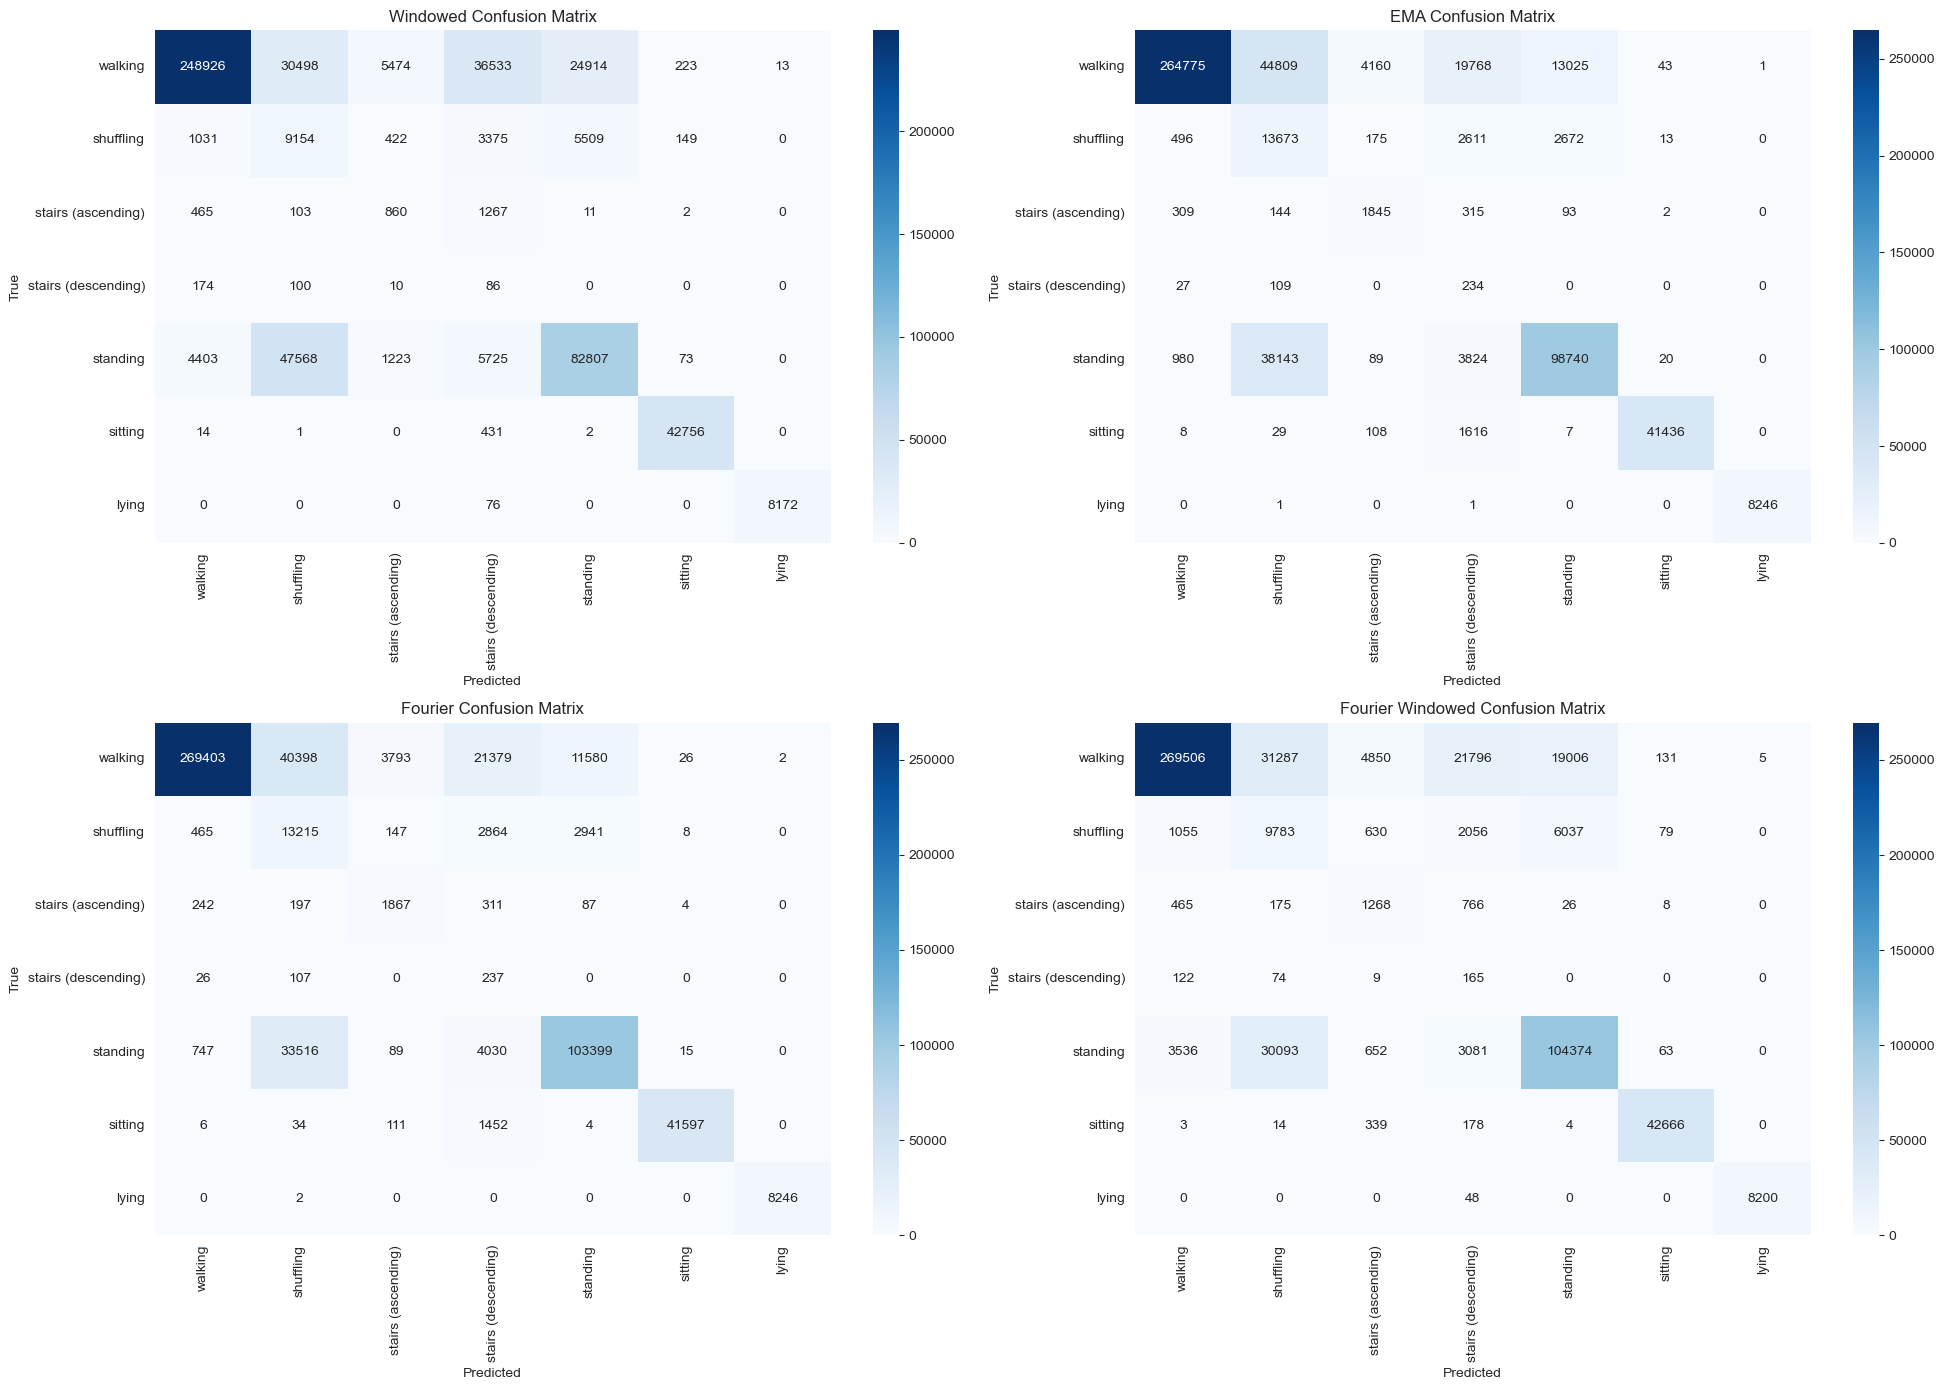

In [92]:
# Let's now plot the confusion matrix for the best version of each of these preprocessing methods
plt.figure(figsize=(20, 14))

conf_matrix_windowed = confusion_matrix(y_test_decoded_window, y_pred_decoded_window)
conf_matrix_ema = confusion_matrix(y_test_decoded_ema, y_pred_decoded_ema)
conf_matrix_fourier = confusion_matrix(y_test_decoded_fourier, y_pred_decoded_fourier)
conf_matrix_fourier_window = confusion_matrix(y_test_decoded_fourier_window, y_pred_decoded_fourier_window)

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix_windowed, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Windowed Confusion Matrix')

plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_ema, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EMA Confusion Matrix')

plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix_fourier, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Fourier Confusion Matrix')

plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix_fourier_window, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Fourier Windowed Confusion Matrix')

plt.tight_layout()
plt.show()

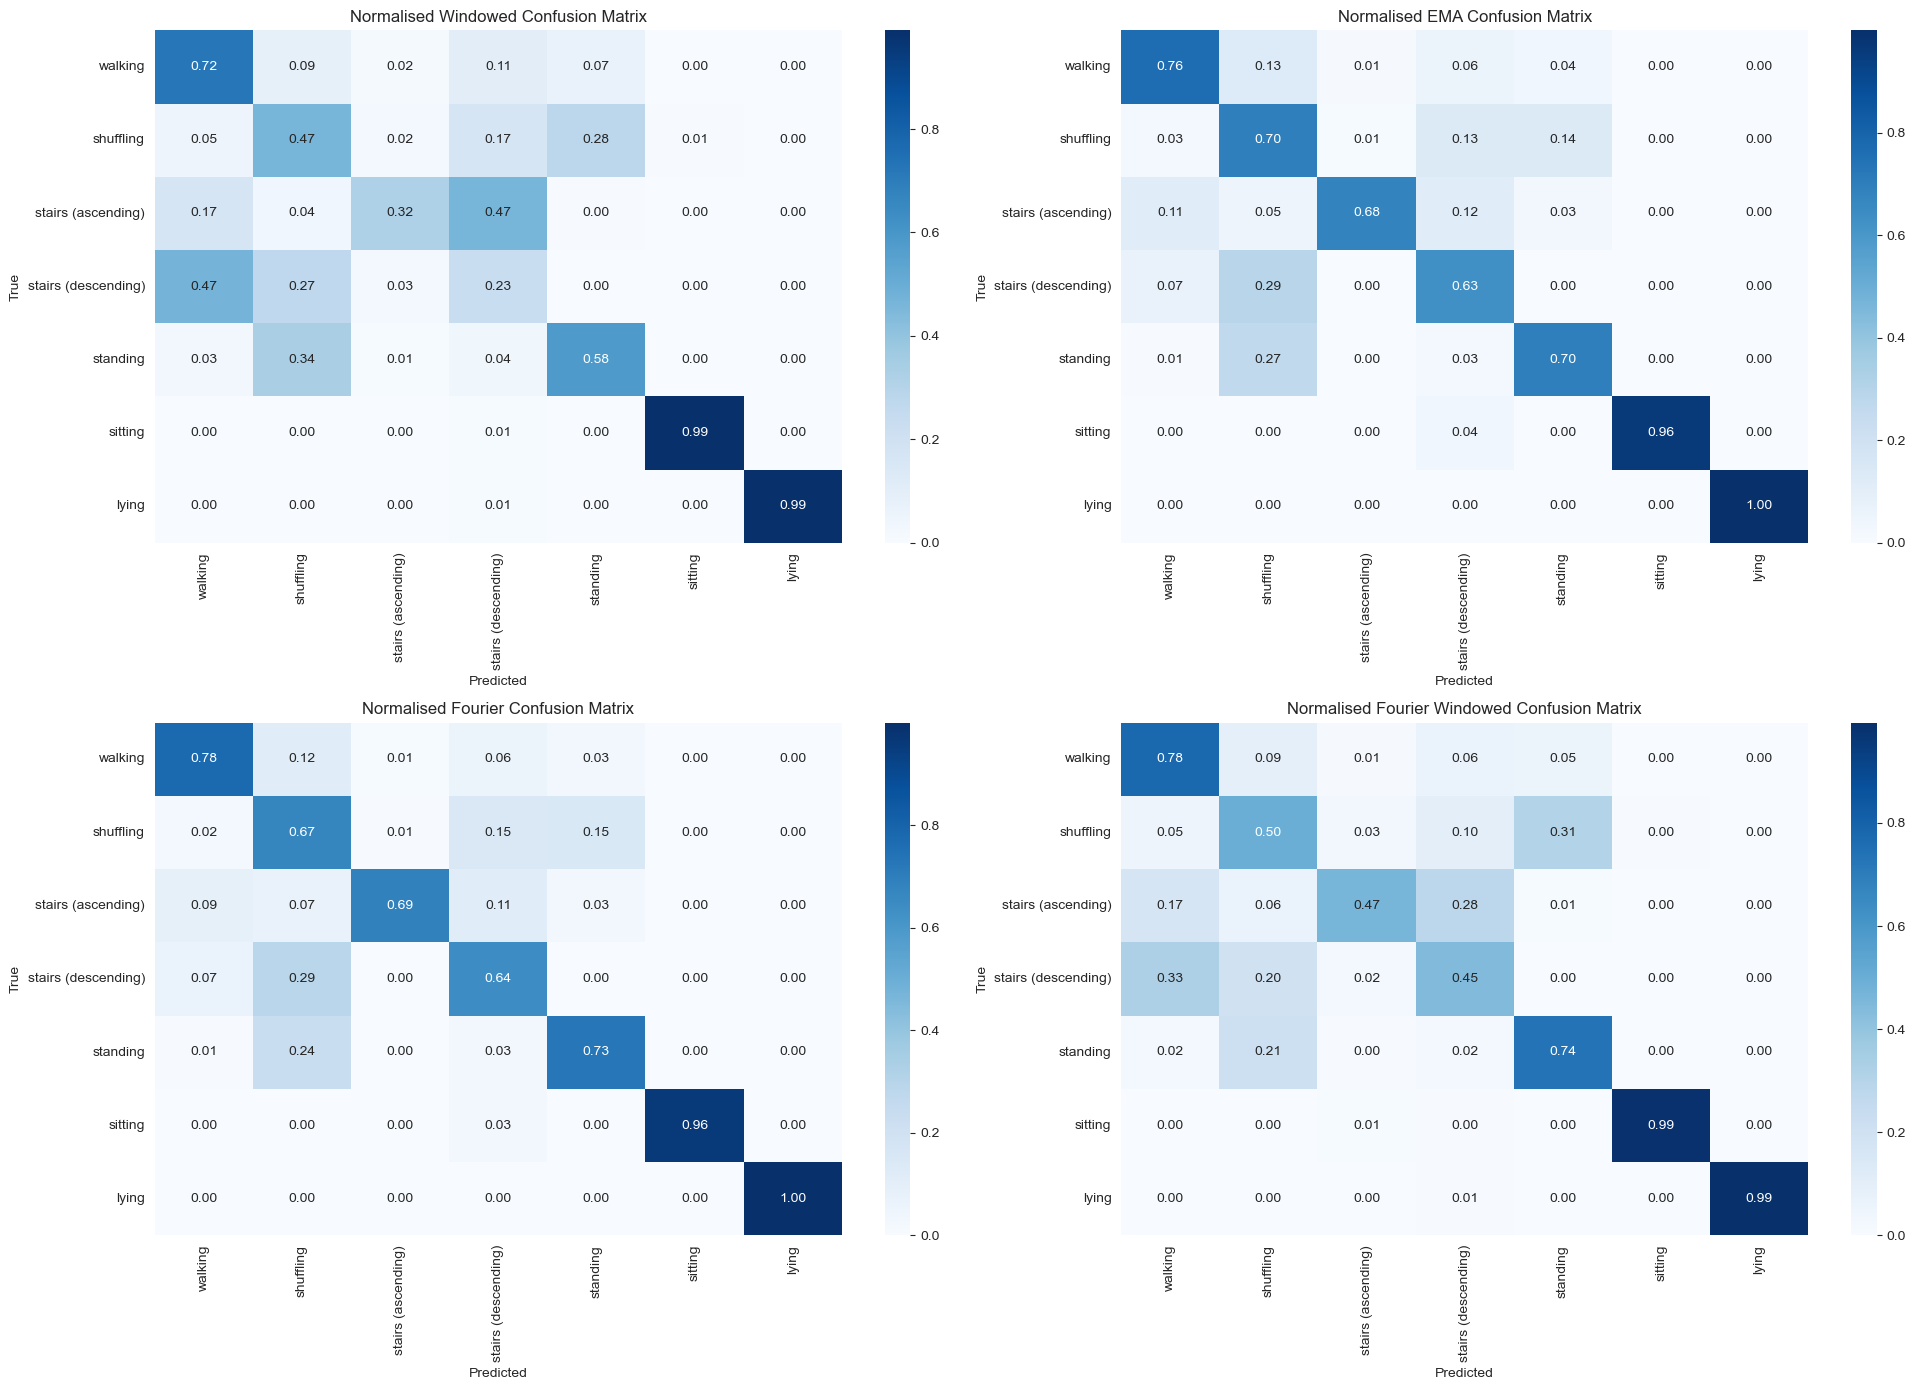

In [93]:
# Let's plot the normalised confusion matrix for the best version of each of these preprocessing methods

conf_matrix_windowed_norm = conf_matrix_windowed / conf_matrix_windowed.sum(axis=1)[:, np.newaxis]
conf_matrix_ema_norm = conf_matrix_ema / conf_matrix_ema.sum(axis=1)[:, np.newaxis]
conf_matrix_fourier_norm = conf_matrix_fourier / conf_matrix_fourier.sum(axis=1)[:, np.newaxis]
conf_matrix_fourier_window_norm = conf_matrix_fourier_window / conf_matrix_fourier_window.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix_windowed_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Windowed Confusion Matrix')

plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_ema_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised EMA Confusion Matrix')

plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix_fourier_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Fourier Confusion Matrix')

plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix_fourier_window_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Fourier Windowed Confusion Matrix')

plt.tight_layout()
plt.show()

In [94]:
# Let's print the classification report for the best version of each of these preprocessing methods

report_windowed = classification_report(y_test_decoded_window, y_pred_decoded_window, target_names=labels)
report_ema = classification_report(y_test_decoded_ema, y_pred_decoded_ema, target_names=labels)
report_fourier = classification_report(y_test_decoded_fourier, y_pred_decoded_fourier, target_names=labels)
report_fourier_windowed = classification_report(y_test_decoded_fourier_window, y_pred_decoded_fourier_window, target_names=labels)

print('Windowed Classification Report')
print(report_windowed)
print('-' * 100)

print('EMA Classification Report')
print(report_ema)
print('-' * 100)

print('Fourier Classification Report')
print(report_fourier)
print('-' * 100)

print('Fourier Windowed Classification Report')
print(report_fourier_windowed)

Windowed Classification Report
                     precision    recall  f1-score   support

            walking       0.98      0.72      0.83    346581
          shuffling       0.10      0.47      0.17     19640
 stairs (ascending)       0.11      0.32      0.16      2708
stairs (descending)       0.00      0.23      0.00       370
           standing       0.73      0.58      0.65    141799
            sitting       0.99      0.99      0.99     43204
              lying       1.00      0.99      0.99      8248

           accuracy                           0.70    562550
          macro avg       0.56      0.61      0.54    562550
       weighted avg       0.88      0.70      0.77    562550

----------------------------------------------------------------------------------------------------
EMA Classification Report
                     precision    recall  f1-score   support

            walking       0.99      0.76      0.86    346581
          shuffling       0.14      0.70     